<h1>
    <span style="color:darkgrey">
         Анализ датасета: Brazilian E-Commerce Public Dataset by Olist
    </span>
</h1>

----

<h2>
    <span style="color:darkgrey">
        Общая информация о датасете: 
    </span>
</h2>

----

Это бразильская публичная база данных электронной коммерции о заказах, сделанных в Olist Store. Набор данных содержит информацию о 100 тыс. заказов с 2016 по 2018 год, сделанных на нескольких торговых площадках в Бразилии. Ее возможности позволяют просматривать заказы по нескольким параметрам: от статуса заказа, цены, оплаты и грузоперевозки до местоположения клиента, атрибутов товара.

Это реальные коммерческие данные, они были анонимизированы.

----

<h2>
    <span style="color:darkgrey">
        Продакт-менеджер попросил вас проанализировать совершенные покупки и ответить на следующие вопросы: 
    </span>
</h2>

----

1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

5. Используя `pandas`, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким `retention` на 3й месяц.

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя `python`, построй **RFM-сегментацию** пользователей, чтобы качественно оценить свою аудиторию.


Файлы:

- `olist_customers_datase.csv` — таблица с уникальными идентификаторами пользователей
  - `customer_id` — позаказный идентификатор пользователя
  - `customer_unique_id` —  уникальный идентификатор пользователя  (аналог номера паспорта)
  - `customer_zip_code_prefix` —  почтовый индекс пользователя
  - `customer_city` —  город доставки пользователя
  - `customer_state` —  штат доставки пользователя


- `olist_orders_dataset.csv` —  таблица заказов
  - `order_id` —  уникальный идентификатор заказа (номер чека)
  - `customer_id` —  позаказный идентификатор пользователя
  - `order_status` —  статус заказа
  - `order_purchase_timestamp` —  время создания заказа
  - `order_approved_at` —  время подтверждения оплаты заказа
  - `order_delivered_carrier_date` —  время передачи заказа в логистическую службу
  - `order_delivered_customer_date` —  время доставки заказа
  - `order_estimated_delivery_date` —  обещанная дата доставки


- `olist_order_items_dataset.csv` —  товарные позиции, входящие в заказы
  - `order_id` —  уникальный идентификатор заказа (номер чека)
  - `order_item_id` —  идентификатор товара внутри одного заказа
  - `product_id` —  ид товара (аналог штрихкода)
  - `seller_id` — ид производителя товара
  - `shipping_limit_date` —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
  - `price` —  цена за единицу товара
  - `freight_value` —  вес товара

Уникальные статусы заказов в таблице `olist_orders_dataset`:
- `created` —  создан
- `approved` —  подтверждён
- `invoiced` —  выставлен счёт
- `processing` —  в процессе сборки заказа
- `shipped` —  отгружен со склада
- `delivered` —  доставлен пользователю
- `unavailable` —  недоступен
- `canceled` —  отменён

----

<h2>
    <span style="color:darkgrey">
        0. Загрузка и предобработка данных
    </span>
</h2>

----

> Импорт необходимых библиотек, открытие `.csv` файлов и вывод общей информации

In [1]:
import pandas as pd
import numpy as np
import requests
from urllib.parse import urlencode
from operator import attrgetter
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [2]:
# использрвание api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key_orders = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw' 
public_key_customers = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
public_key_items = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg' 
    
# получение url 
final_url_orders = base_url + urlencode(dict(public_key=public_key_orders))
final_url_customers = base_url + urlencode(dict(public_key=public_key_customers))
final_url_items = base_url + urlencode(dict(public_key=public_key_items))

response_orders = requests.get(final_url_orders)
response_customers = requests.get(final_url_customers)
response_items = requests.get(final_url_items)
 
download_url_orders = response_orders.json()['href']
download_url_customers = response_customers.json()['href'] 
download_url_items = response_items.json()['href'] 

# загрузка файлов
download_response_orders = requests.get(download_url_orders)
download_response_customers = requests.get(download_url_customers)
download_response_items = requests.get(download_url_items)

In [3]:
customer_df = pd.read_csv(download_url_customers)
customer_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [5]:
# предустановка типа данных "datetime" для некоторых столбцов

order_df = pd.read_csv(download_url_orders, parse_dates=[3, 4, 5, 6, 7])
order_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [6]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [7]:
items_df = pd.read_csv(download_url_items, parse_dates=[4])
items_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [8]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


> Детальное расмотрение пропусков в датафрейме `order_df`

In [9]:
# созание нового датафрейма, в который будут записоваться отфильтрованные данные
order_df_treated = order_df

In [10]:
order_df_treated.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

> Вывод статусов заказов, имеющих пропуски в столбце `order_approved_at`(время подтверждения оплаты заказа)

In [11]:
order_df_treated.query('order_approved_at == "NaN"').order_status.unique()

array(['canceled', 'delivered', 'created'], dtype=object)

> Пропуски в столбце `order_approved_at`, имеют статус заказа `canceled`- отменен, `delivered` - доставлен пользователю, `created` - создан. Пропуски со статусом `created` не удаляются, т.к. оплата происходит после создания заказа

> Вывод подробной информации по пропускам со статусои заказа `delivered`

In [12]:
order_df_treated.query('order_approved_at == "NaN"').query('order_status == "delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


   > Пропуски в столбце `order_approved_at`, которые имеют статус `delivered` не подлежат удалению, т.к. это доставленные заказы (имеются данные о дате доставки этих заказов в столбце `order_delivered_customer_date`(время доставки заказа)). Предположительно из-за технического сбоя время и дата оплатны заказа не записались в столбец `order_approved_at`

> Вывод подробной информации по пропускам со статусои заказа `canceled`

In [13]:
order_df_treated.query('order_approved_at == "NaN"').query('order_status == "canceled"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17
1868,df8282afe61008dc26c6c31011474d02,aa797b187b5466bc6925aaaa4bb3bed1,canceled,2017-03-04 12:14:30,NaT,NaT,NaT,2017-04-10
2029,8d4c637f1accf7a88a4555f02741e606,b1dd715db389a2077f43174e7a675d07,canceled,2018-08-29 16:27:49,NaT,NaT,NaT,2018-09-13
2161,7a9d4c7f9b068337875b95465330f2fc,7f71ae48074c0cfec9195f88fcbfac55,canceled,2017-05-01 16:12:39,NaT,NaT,NaT,2017-05-30
...,...,...,...,...,...,...,...,...
97696,5a00b4d35edffc56b825c3646a99ba9d,6a3bdf004ca96338fb5fad1b8d93c2e6,canceled,2017-07-02 15:38:46,NaT,NaT,NaT,2017-07-25
98415,227c804e2a44760671a6a5697ea549e4,62e7477e75e542243ee62a0ba73f410f,canceled,2017-09-28 15:02:56,NaT,NaT,NaT,2017-10-16
98909,e49e7ce1471b4693482d40c2bd3ad196,e4e7ab3f449aeb401f0216f86c2104db,canceled,2018-08-07 11:16:28,NaT,NaT,NaT,2018-08-10
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01


 > Пропуски в столбце `order_approved_at`, которые имеют статус `canceled` не подлежат удалению, т.к. эти заказы отменили до момента оплаты

> Вывод статусов заказов, имеющих пропуски в столбце `order_delivered_carrier_date`(время передачи заказа в логистическую службу)

In [14]:
order_df_treated.query('order_delivered_carrier_date == "NaN"').order_status.unique()

array(['invoiced', 'processing', 'unavailable', 'canceled', 'created',
       'approved', 'delivered'], dtype=object)

> Пропуски в столбце `order_delivered_carrier_date` имеют статусы заказа `invoiced` - выставлен счёт, `processing` - в процессе сборки заказа, `unavailable` - недоступен, `canceled`, `approved`, `delivered`
>
> Т.к. заказы, которые еще не были доставленны по различным причинам, могут иметь пропуски в данном столбце, подлежат удалению только те заказы, которые имеют статус `delivered`

> Вывод подробной информации по пропускам со статусои заказа `delivered`

In [15]:
order_df.query('order_delivered_carrier_date == "NaN"').query('order_status == "delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
73222,2aa91108853cecb43c84a5dc5b277475,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaT,2017-11-20 19:44:47,2017-11-14
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23


> Строка с индексом `73222` не подлежит удалению, т.к. имеет дату доставки и предположительно по техническим причинам в ней не сохранилась информация о времени передачи заказа в логистическую службу
>
> Удаление строки с индексом `92643` из столбца `order_delivered_carrier_date` будет произведено ниже вместе с удалением пропусков в столбце `order_delivered_customer_date`

> Вывод статусов заказов, имеющих пропуски в столбце `order_delivered_customer_date`(время доставки заказа)

In [16]:
order_df_treated.query('order_delivered_customer_date == "NaN"').order_status.unique()

array(['invoiced', 'shipped', 'processing', 'unavailable', 'canceled',
       'delivered', 'created', 'approved'], dtype=object)

> Пропуски в столбце `order_delivered_customer_date` имеют статусы заказа `invoiced`, `shipped` - отгружен со склада, `processing`, `unavailable`, `canceled`, `delivered`, `created`, `approved`
>
> Т.к. заказы, которые еще не были доставленны по различным причинам, могут иметь пропуски в данном столбце, подлежат удалению только те заказы, которые имеют статус `delivered`

> Вывод подробной информации по пропускам со статусои заказа `delivered`

In [17]:
order_df.query('order_delivered_customer_date == "NaN"').query('order_status == "delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


> Удаление пропусков из столбца `order_delivered_customer_date`

In [18]:
# создание списка с индексами строк, которые будут удалены
index_to_drop = order_df_treated.query('order_delivered_customer_date == "NaN"') \
                                .query('order_status == "delivered"') \
                                .reset_index()

index_to_drop = index_to_drop['index']
index_to_drop

0     3002
1    20618
2    43834
3    79263
4    82868
5    92643
6    97647
7    98038
Name: index, dtype: int64

In [19]:
order_df_treated = order_df_treated.drop(index = index_to_drop).reset_index(drop=True)

> Вывод обновленной информации о пропусках в датафрейме `order_df_treated`

In [20]:
order_df_treated.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1782
order_delivered_customer_date    2957
order_estimated_delivery_date       0
dtype: int64

----

<h2>
    <span style="color:darkgrey">
         1. Сколько у нас пользователей, которые совершили покупку только один раз?
    </span>
</h2>

----

> Совершенной покупкой, которая принесла прибыль, можно считать только те заказы, которые подходят под оба нижеперечисленных критерия:
> - имеют данные о подтверждении оплаты;
> - были доставлены покупателю (если заказ не был доставлен по какой-либо причине, даже если не закончился срок предпологаемой доставки, покупатель может запросить возврат средств, соответсвенно компания не получит прибыли с этого заказа, что может повлиять на дальнейший анализ).
>
> Такие критерии были выбранны для получения максимально достоверной информации о полученой прибыли

> Создание датафрейма с данными, который соответствует критериям совершенной покупи

In [21]:
order_df_completed_purchases = order_df_treated.query('order_status == "delivered"')\
                                               .query('order_approved_at != "NaN"')

> Объединение датафреймов с уникальными идентификаторами пользователей(`customer_df`) и совершенных заказов `order_df_completed_purchases` по столбцу `customer_id` так, чтобы остались только такие `customer_id` как в подготовленном датафрейме `order_df_completed_purchases`

In [22]:
one_completed_purchases_df = order_df_completed_purchases.merge(customer_df, how='inner', on='customer_id')

In [23]:
one_completed_purchases_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


> Вычисление количества пользователей совершивших покупку только один раз

In [24]:
one_completed_purchases_df = one_completed_purchases_df.groupby('customer_unique_id', as_index = False)\
                                                       .agg({'order_id' : 'count'})\
                                                       .query("order_id == 1")\
                                                       .customer_unique_id.count()
one_completed_purchases_df

90537

**Ответ: *90537***

> `90537` покупателей из `96456` совершили покупку один раз, вычислим какой процент они составляют от всех покупателей

In [25]:
one_purchase_percent = (one_completed_purchases_df / order_df_completed_purchases.shape[0]) * 100
print(f'Около {one_purchase_percent.round(2)}% покупателей совершили покупку один раз')

Около 93.86% покупателей совершили покупку один раз


----

<h2>
    <span style="color:darkgrey">
         2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
    </span>
</h2>

----

> Недоставленный заказ - заказ, который подходит под все нижеперечисленные критерии:
>
> - товар в заказе был недоступен;
> - заказ был отменен;
> - превышен ожидаемый срок доставки больше чем на 41 день (обоснование выбранного срока изложено в ячейках)

> Создание датафрейма с отстутвующими значениями в столбце `order_delivered_customer_date` - время доставки заказа из `order_df_treated`

In [26]:
order_not_delivered_df = order_df_treated.query('order_delivered_customer_date == "NaN"').reset_index(drop=True)
order_not_delivered_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
1,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
2,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
3,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
4,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07


> Расчет среднего срока доставки c момента передачи в курьерскую службу и до даты фактической доставки

> Создание нового датафрейма `delivery_time` в который записаны только доставленные заказы

In [27]:
delivery_time = order_df_treated.query('order_status == "delivered"')\
                                .query('order_delivered_carrier_date != "NaN"')\
                                .reset_index(drop=True)
delivery_time.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


> Вычисление количества дней для каждой осущетвленной доставки
>
> Вывод гистограммы зависимости количества заказов доставленных за определенное количество дней

In [28]:
delivery_time = delivery_time.order_delivered_customer_date.dt.date - delivery_time.order_delivered_carrier_date.dt.date
delivery_time = (delivery_time / np.timedelta64(1, 'D')).astype(int)\
                                                        .to_frame()\
                                                        .reset_index(drop=True)

Text(0.5, 0, 'Days')

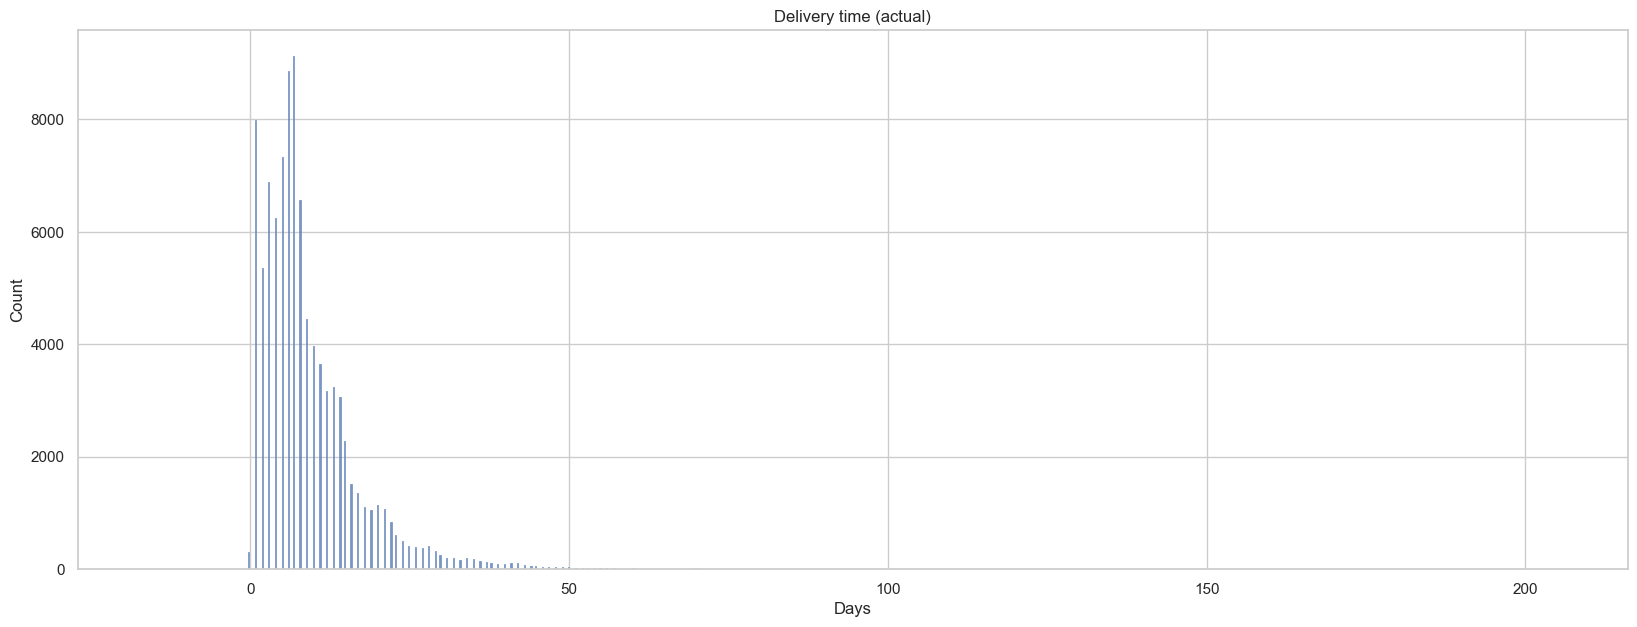

In [29]:
sns.histplot(data=delivery_time, x=0)
plt.title('Delivery time (actual)')
plt.xlabel('Days')

> Вывод медианного значения срока доствки, а также 99 процентиля

In [30]:
mean_del_time = delivery_time.mean()
mean_del_time

0    9.282526
dtype: float64

In [31]:
max_allowed_del_time = delivery_time.quantile(.99)
max_allowed_del_time

0    41.0
Name: 0.99, dtype: float64

> Максимально допусимый срок доставки - 41 день, т.к. 99% заказов были доставленны в указанный срок

> Создание датафрейма `out_of_del_time`в котором будут хранится те заказы, срок доставки которых превысил 41 день и имеют статус `shipped`
>
> Добавление колонки с данными о крайней дате ожидания достваки

In [32]:
out_of_del_time = order_not_delivered_df
out_of_del_time['max_carrier_date'] = out_of_del_time.order_delivered_carrier_date + timedelta(days=41)
out_of_del_time.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,max_carrier_date
0,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,NaT
1,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,2018-07-16 14:32:00
2,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21,NaT
3,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03,NaT
4,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,2018-02-21 19:39:23


> Заказ не доставлен, если находится в статусе `shipped`, и привышен срок доставки

In [33]:
out_of_del_time = out_of_del_time.query('(order_status == "shipped") and (max_carrier_date > order_estimated_delivery_date)')
out_of_del_time.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,max_carrier_date
1,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,2018-07-16 14:32:00
4,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,2018-02-21 19:39:23
5,36530871a5e80138db53bcfd8a104d90,4dafe3c841d2d6cc8a8b6d25b35704b9,shipped,2017-05-09 11:48:37,2017-05-11 11:45:14,2017-05-11 13:21:47,NaT,2017-06-08,2017-06-21 13:21:47
6,4d630f57194f5aba1a3d12ce23e71cd9,6d491c9fe2f04f6e2af6ec033cd8907c,shipped,2017-11-17 19:53:21,2017-11-18 19:50:31,2017-11-22 17:28:34,NaT,2017-12-13,2018-01-02 17:28:34
8,3b4ad687e7e5190db827e1ae5a8989dd,1a87b8517b7d31373b50396eb15cb445,shipped,2018-06-28 12:52:15,2018-06-28 13:11:09,2018-07-04 15:20:00,NaT,2018-08-03,2018-08-14 15:20:00


> Вывод статусов заказов в датафрейме `order_not_delivered_df`

In [34]:
order_not_delivered_df.order_status.unique()

array(['invoiced', 'shipped', 'processing', 'unavailable', 'canceled',
       'created', 'approved'], dtype=object)

> Создание датафрема `undelivered_df` со всеми не доставленными заказами.
> В него входят заказы со статусами `unavailable` — недоступен, `canceled` — отменён, т.к. остальные статусы подразумевают, что заказы находятся в процессе доставки или обработки, а тажке заказы с превышенным сроком доставки

In [35]:
order_not_delivered_df = order_not_delivered_df.query("(order_status in ['unavailable', 'canceled']) or (order_id in @out_of_del_time.order_id)")
order_not_delivered_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,max_carrier_date
1,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,2018-07-16 14:32:00
4,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,2018-02-21 19:39:23
5,36530871a5e80138db53bcfd8a104d90,4dafe3c841d2d6cc8a8b6d25b35704b9,shipped,2017-05-09 11:48:37,2017-05-11 11:45:14,2017-05-11 13:21:47,NaT,2017-06-08,2017-06-21 13:21:47
6,4d630f57194f5aba1a3d12ce23e71cd9,6d491c9fe2f04f6e2af6ec033cd8907c,shipped,2017-11-17 19:53:21,2017-11-18 19:50:31,2017-11-22 17:28:34,NaT,2017-12-13,2018-01-02 17:28:34
7,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05,NaT


> Сортировка по месяцам

In [36]:
order_not_delivered_df['year_month'] = order_not_delivered_df['order_estimated_delivery_date']\
    .dt.to_period('M')\
    .astype(str)

order_not_delivered_df['year_month'] = pd.to_datetime(order_not_delivered_df['year_month'])

order_not_delivered_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,max_carrier_date,year_month
1,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,2018-07-16 14:32:00,2018-06-01
4,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,2018-02-21 19:39:23,2018-02-01
5,36530871a5e80138db53bcfd8a104d90,4dafe3c841d2d6cc8a8b6d25b35704b9,shipped,2017-05-09 11:48:37,2017-05-11 11:45:14,2017-05-11 13:21:47,NaT,2017-06-08,2017-06-21 13:21:47,2017-06-01
6,4d630f57194f5aba1a3d12ce23e71cd9,6d491c9fe2f04f6e2af6ec033cd8907c,shipped,2017-11-17 19:53:21,2017-11-18 19:50:31,2017-11-22 17:28:34,NaT,2017-12-13,2018-01-02 17:28:34,2017-12-01
7,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05,NaT,2017-12-01


> Построение гистограммы количества не доставленных заказов по месяцам, разбивка по статусам заказов

<AxesSubplot:xlabel='year_month', ylabel='Count'>

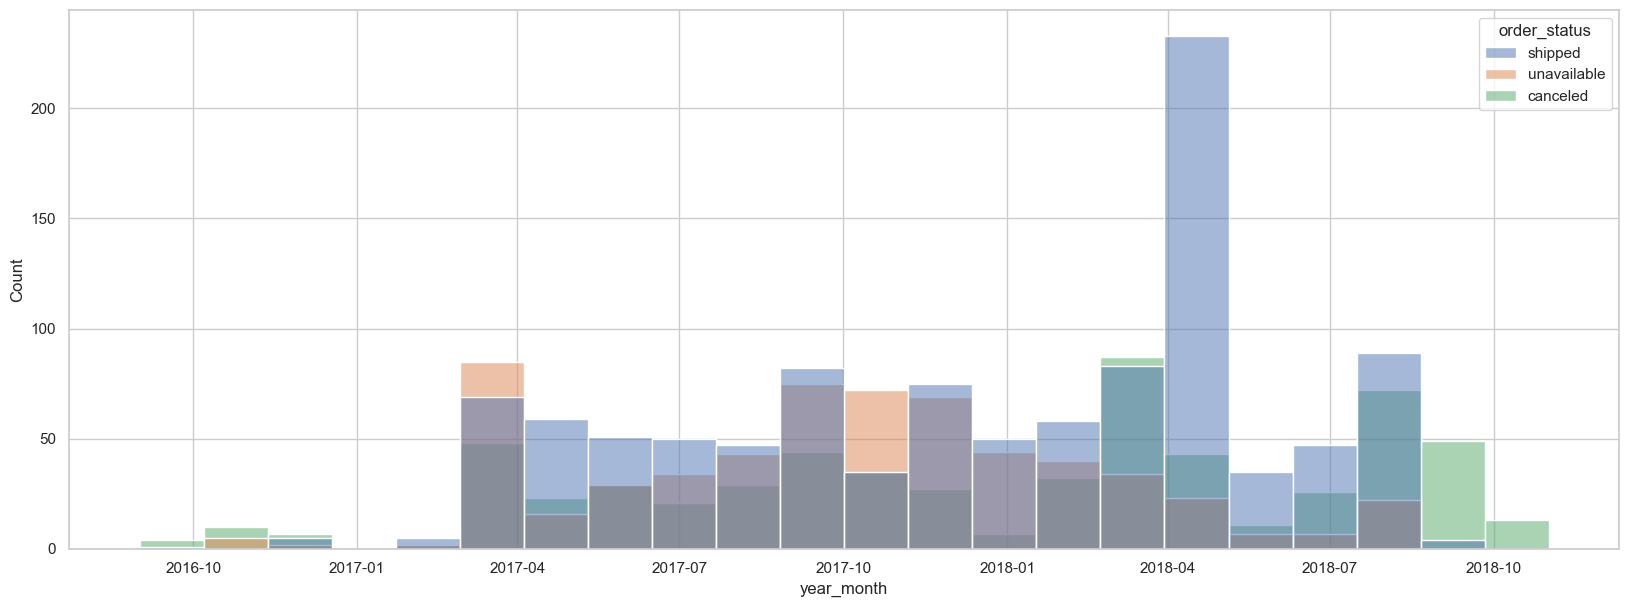

In [37]:
sns.histplot(data=order_not_delivered_df, x="year_month", hue='order_status')

> Из данной гистограммы следует, что большинство не достваленных заказов имеют статус `shipped`, т.е. данные заказы не доставленны из-за проблем с логистикой

> Расчет количеста не доставленных заказов по месяцам

In [38]:
order_not_delivered_df = order_not_delivered_df.groupby(['year_month','order_status'], as_index=False)\
                                               .agg({'order_id': 'count'})
order_not_delivered_df

,year_month,order_status,order_id
0,2016-09-01,canceled,1
1,2016-10-01,canceled,3
2,2016-10-01,shipped,1
3,2016-11-01,canceled,10
4,2016-11-01,unavailable,5
...,...,...,...
64,2018-08-01,unavailable,22
65,2018-09-01,canceled,49
66,2018-09-01,shipped,4
67,2018-10-01,canceled,12


In [39]:
order_not_delivered_df.groupby('order_status').agg({'order_id' : 'mean'}).round()

,order_id
order_status,
canceled,24.0
shipped,49.0
unavailable,29.0


**Ответ:**
 - **не было товара на складе на момент оформления заказа (unavailable): 30 заказов/месяц**
 - **заказ был отменен (canceled): 24 заказов/месяц**
 - **проблемы с логистикой (shipped): 49 заказов/месяц**

----

<h2>
    <span style="color:darkgrey">
         3. По каждому товару определить, в какой день недели товар чаще всего покупается
    </span>
</h2>

----

> Создание датафрема `week_id_df` из данных заказов и товарных позиций, входящих в заказы

In [40]:
week_id_df = order_df_treated.merge(items_df, on='order_id')\
                             [['product_id', 'order_purchase_timestamp', 'order_status']]
week_id_df.head()

,product_id,order_purchase_timestamp,order_status
0,87285b34884572647811a353c7ac498a,2017-10-02 10:56:33,delivered
1,595fac2a385ac33a80bd5114aec74eb8,2018-07-24 20:41:37,delivered
2,aa4383b373c6aca5d8797843e5594415,2018-08-08 08:38:49,delivered
3,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11-18 19:28:06,delivered
4,65266b2da20d04dbe00c5c2d3bb7859e,2018-02-13 21:18:39,delivered


> Добавление колонки `week_day` с названием дня недели в которой был создан заказ

In [41]:
week_id_df['week_day'] = week_id_df.order_purchase_timestamp.dt.strftime("%A")
week_id_df.head()

,product_id,order_purchase_timestamp,order_status,week_day
0,87285b34884572647811a353c7ac498a,2017-10-02 10:56:33,delivered,Monday
1,595fac2a385ac33a80bd5114aec74eb8,2018-07-24 20:41:37,delivered,Tuesday
2,aa4383b373c6aca5d8797843e5594415,2018-08-08 08:38:49,delivered,Wednesday
3,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11-18 19:28:06,delivered,Saturday
4,65266b2da20d04dbe00c5c2d3bb7859e,2018-02-13 21:18:39,delivered,Tuesday


> Групировка по товарам и дням недели и подсчет количества заказов для каждого дня

In [42]:
week_id_df = week_id_df.groupby(['product_id', 'week_day'], as_index=False)\
                       .agg({'order_status': 'count'})\
                       .rename(columns = {'order_status': 'count_order'})\
                       .sort_values('count_order', ascending = False)\
                       .reset_index(drop=True)
week_id_df.head()

,product_id,week_day,count_order
0,422879e10f46682990de24d770e7f83d,Wednesday,93
1,99a4788cb24856965c36a24e339b6058,Monday,92
2,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
3,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,87
4,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85


> Создание датафрейма `new_max` с уникальными id товарами и их максимальным количеством продаж

In [43]:
new_max = week_id_df.groupby('product_id', as_index = False)\
                    .max()\
                    .sort_values(by='count_order', ascending=False)
new_max.head()

,product_id,week_day,count_order
8612,422879e10f46682990de24d770e7f83d,Wednesday,93
19741,99a4788cb24856965c36a24e339b6058,Wednesday,92
22110,aca2eb7d00ea1a7b8ebd4e68314663af,Wednesday,89
10866,53b36df67ebb7c41585e8d54d6772e08,Wednesday,76
7363,389d119b48cf3043d311335e499d9c6b,Wednesday,67


> Объединение датафрема `week_id_df` и `new_max`, для избежания потери данных, когда некоторые товары могут иметь одинаковое максимальное количество продаж в разные дни недели

In [44]:
df_merg_max = week_id_df.merge(new_max[['product_id','count_order']], on = ('product_id'))
df_merg_max.head()

,product_id,week_day,count_order_x,count_order_y
0,422879e10f46682990de24d770e7f83d,Wednesday,93,93
1,422879e10f46682990de24d770e7f83d,Thursday,79,93
2,422879e10f46682990de24d770e7f83d,Friday,77,93
3,422879e10f46682990de24d770e7f83d,Tuesday,67,93
4,422879e10f46682990de24d770e7f83d,Monday,64,93


> Вывод дней недели с максимальным количесвом заказов по каждому товару

In [45]:
df_merg_max[df_merg_max.count_order_x >= df_merg_max.count_order_y].head()

,product_id,week_day,count_order_x,count_order_y
0,422879e10f46682990de24d770e7f83d,Wednesday,93,93
7,99a4788cb24856965c36a24e339b6058,Monday,92,92
14,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89,89
21,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76,76
28,368c6c730842d78016ad823897a372db,Friday,67,67


----

<h2>
    <span style="color:darkgrey">
         4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?
    </span>
</h2>

----

> Создание датафрейма `week_mean_customer_pursh_df` из датафрейма совершенных покупок(согласно определению покупки из п.1) и датафрейма с уникальными идентификаторами пользователей

In [46]:
week_mean_customer_pursh_df = order_df_completed_purchases.merge(customer_df[['customer_id','customer_unique_id']], on = ('customer_id'))
week_mean_customer_pursh_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6


> Удаление лишних колонок. Время покупки определяется по колонке `order_approved_at` - время подтверждения оплаты заказа

In [47]:
week_mean_customer_pursh_df = week_mean_customer_pursh_df.drop(columns=['order_status', 'order_purchase_timestamp',\
                                                                        'order_delivered_carrier_date',\
                                                                        'order_delivered_customer_date',\
                                                                        'order_estimated_delivery_date'])
week_mean_customer_pursh_df.head()

,order_id,customer_id,order_approved_at,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-26 03:24:27,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:55:23,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:45:59,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 22:20:29,72632f0f9dd73dfee390c9b22eb56dd6


> Расчет и вывод количества недель в месяце

In [48]:
week_mean_customer_pursh_df['weeks_in_month'] = week_mean_customer_pursh_df.order_approved_at.dt.days_in_month / 7
week_mean_customer_pursh_df.head()

,order_id,customer_id,order_approved_at,customer_unique_id,weeks_in_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff,4.428571
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-26 03:24:27,af07308b275d755c9edb36a90c618231,4.428571
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:55:23,3a653a41f6f9fc3d2a113cf8398680e8,4.428571
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:45:59,7c142cf63193a1473d2e66489a9ae977,4.285714
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 22:20:29,72632f0f9dd73dfee390c9b22eb56dd6,4.000000


> Добавление новой колонки отображающей месяц и год покупки

In [49]:
week_mean_customer_pursh_df['order_approved_at'] = week_mean_customer_pursh_df.order_approved_at.dt.strftime('%Y-%m')
week_mean_customer_pursh_df = week_mean_customer_pursh_df.rename(columns={"order_approved_at": "year-month"})
week_mean_customer_pursh_df.head()

,order_id,customer_id,year-month,customer_unique_id,weeks_in_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10,7c396fd4830fd04220f754e42b4e5bff,4.428571
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07,af07308b275d755c9edb36a90c618231,4.428571
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08,3a653a41f6f9fc3d2a113cf8398680e8,4.428571
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11,7c142cf63193a1473d2e66489a9ae977,4.285714
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02,72632f0f9dd73dfee390c9b22eb56dd6,4.000000


> Групировка данных по колонкам `customer_unique_id`, `year-month`, `weeks_in_month`, расчет количества покупок для каждого уникального пользователя

In [50]:
week_mean_customer_pursh_df = week_mean_customer_pursh_df\
                              .groupby(by=['customer_unique_id', 'year-month', 'weeks_in_month'], as_index=False)\
                              .agg({'order_id': 'count'})\
                              .rename(columns={'order_id': 'purshases'})\
                              .sort_values(by='purshases', ascending=False)
week_mean_customer_pursh_df.head()

,customer_unique_id,year-month,weeks_in_month,purshases
7100,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,4.428571,6
60356,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4.000000,4
14054,25a560b9a6006157838aab1bdbd68624,2017-04,4.285714,4
74542,c8460e4251689ba205045f3ea17884a1,2018-08,4.428571,4
49114,83e7958a94bd7f74a9414d8782f87628,2017-01,4.428571,4


> Добавление колонки `purshases_per_week` с количеством покупок в неделю для каждого уникального пользователя

In [51]:
week_mean_customer_pursh_df['purshases_per_week'] = week_mean_customer_pursh_df.purshases / week_mean_customer_pursh_df.weeks_in_month
week_mean_customer_pursh_df.head()

,customer_unique_id,year-month,weeks_in_month,purshases,purshases_per_week
7100,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,4.428571,6,1.354839
60356,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4.000000,4,1.000000
14054,25a560b9a6006157838aab1bdbd68624,2017-04,4.285714,4,0.933333
74542,c8460e4251689ba205045f3ea17884a1,2018-08,4.428571,4,0.903226
49114,83e7958a94bd7f74a9414d8782f87628,2017-01,4.428571,4,0.903226


----

<h2>
    <span style="color:darkgrey">
         5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на третий месяц
    </span>
</h2>

----

> Определение параметров перед проведением когортного анализа:
>
>1.  **Признак формирования когорты** — покупка;
>2.  **Размер когорты** — месяц;
>3.  **Отчетный период** — с января по декабрь 2017;
>4.  **Анализируемый ключевой показатель:** retention.
>
>`Retention` - это удержание пользователей, т.е. нужно найти когорту с самым высоким процентом повторных покупок на третий месяц 

> Создание датафрема `order_items_df` из датафрейма совершенных покупок(согласно определению покупки из п.1) и датафрейма с товарными позициями, входящими в заказы

In [52]:
order_items_df = order_df_completed_purchases.merge(items_df[['order_id','product_id', 'price']], on = ('order_id'))
order_items_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,price
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,87285b34884572647811a353c7ac498a,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,595fac2a385ac33a80bd5114aec74eb8,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,aa4383b373c6aca5d8797843e5594415,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,d0b61bfb1de832b15ba9d266ca96e5b0,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,65266b2da20d04dbe00c5c2d3bb7859e,19.90


> Удаление лишних колонок

In [53]:
order_items_df = order_items_df.drop(columns=['order_status', 'order_purchase_timestamp',\
                                              'order_delivered_carrier_date', 'order_delivered_customer_date',\
                                             'order_estimated_delivery_date', 'order_id'])
order_items_df.head()

,customer_id,order_approved_at,product_id,price
0,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,87285b34884572647811a353c7ac498a,29.99
1,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-26 03:24:27,595fac2a385ac33a80bd5114aec74eb8,118.70
2,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:55:23,aa4383b373c6aca5d8797843e5594415,159.90
3,f88197465ea7920adcdbec7375364d82,2017-11-18 19:45:59,d0b61bfb1de832b15ba9d266ca96e5b0,45.00
4,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 22:20:29,65266b2da20d04dbe00c5c2d3bb7859e,19.90


> Объединение с датафреймом `customer_df` для добавления уникальных пользователей 

In [54]:
order_items_df = order_items_df.merge(customer_df, on = ('customer_id'))
order_items_df.head()

,customer_id,order_approved_at,product_id,price,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,87285b34884572647811a353c7ac498a,29.99,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-26 03:24:27,595fac2a385ac33a80bd5114aec74eb8,118.70,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:55:23,aa4383b373c6aca5d8797843e5594415,159.90,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,f88197465ea7920adcdbec7375364d82,2017-11-18 19:45:59,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 22:20:29,65266b2da20d04dbe00c5c2d3bb7859e,19.90,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


> Удаление лишних колонок

In [55]:
order_items_df = order_items_df.drop(columns=['customer_id', 'product_id',\
                                              'customer_zip_code_prefix', 'customer_city',\
                                              'customer_state'])
order_items_df.head()

,order_approved_at,price,customer_unique_id
0,2017-10-02 11:07:15,29.99,7c396fd4830fd04220f754e42b4e5bff
1,2018-07-26 03:24:27,118.70,af07308b275d755c9edb36a90c618231
2,2018-08-08 08:55:23,159.90,3a653a41f6f9fc3d2a113cf8398680e8
3,2017-11-18 19:45:59,45.00,7c142cf63193a1473d2e66489a9ae977
4,2018-02-13 22:20:29,19.90,72632f0f9dd73dfee390c9b22eb56dd6


> Расчет даты первой покупки

In [56]:
first_orders = order_items_df.groupby('customer_unique_id')\
                             .agg({'order_approved_at': 'min'})\
                             .rename(columns={'order_approved_at': 'first_order'})
first_orders.head()

,first_order
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17
0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52


> Объединение даты первой покупки и суммы для каждого уникального пользователя

In [57]:
order_items_meged_df = order_items_df.merge(first_orders, on = ('customer_unique_id'))
order_items_meged_df.head()

,order_approved_at,price,customer_unique_id,first_order
0,2017-10-02 11:07:15,29.99,7c396fd4830fd04220f754e42b4e5bff,2017-09-04 11:43:25
1,2017-09-04 11:43:25,35.39,7c396fd4830fd04220f754e42b4e5bff,2017-09-04 11:43:25
2,2018-07-26 03:24:27,118.70,af07308b275d755c9edb36a90c618231,2018-07-26 03:24:27
3,2018-08-08 08:55:23,159.90,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:55:23
4,2017-11-18 19:45:59,45.00,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59


> Изменение формата даты на "год-месяц"

In [58]:
order_items_meged_df['first_order'] = order_items_meged_df['first_order'].dt.to_period('M')
order_items_meged_df['order_approved_at'] = order_items_meged_df['order_approved_at'].dt.to_period('M')
order_items_meged_df.head()

,order_approved_at,price,customer_unique_id,first_order
0,2017-10,29.99,7c396fd4830fd04220f754e42b4e5bff,2017-09
1,2017-09,35.39,7c396fd4830fd04220f754e42b4e5bff,2017-09
2,2018-07,118.70,af07308b275d755c9edb36a90c618231,2018-07
3,2018-08,159.90,3a653a41f6f9fc3d2a113cf8398680e8,2018-08
4,2017-11,45.00,7c142cf63193a1473d2e66489a9ae977,2017-11


> Добавление колонки `total_orders` в которую будет записано количество покупок

In [59]:
order_items_meged_df['total_orders'] = 0
order_items_meged_df.head()

,order_approved_at,price,customer_unique_id,first_order,total_orders
0,2017-10,29.99,7c396fd4830fd04220f754e42b4e5bff,2017-09,0
1,2017-09,35.39,7c396fd4830fd04220f754e42b4e5bff,2017-09,0
2,2018-07,118.70,af07308b275d755c9edb36a90c618231,2018-07,0
3,2018-08,159.90,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,0
4,2017-11,45.00,7c142cf63193a1473d2e66489a9ae977,2017-11,0


> Составление когорт по дате первой покупки и подсчет количества покупок, уникальных пользователей и суммы для каждой когорты

In [60]:
order_items_meged_df = order_items_meged_df.groupby(['first_order', 'order_approved_at'])\
                                           .agg({'customer_unique_id': 'nunique',\
                                                 'total_orders': 'count',\
                                                 'price': 'sum'})
order_items_meged_df.head()

customer_unique_id  total_orders     price
first_order order_approved_at                                            
2016-09     2016-09                             1             3    134.97
2016-10     2016-10                           262           313  40325.11
            2017-04                             1             1     99.99
            2017-07                             1             1    339.00
            2017-09                             1             1     49.00

> Переименование колонок и изменение индексации

In [61]:
order_items_meged_df = order_items_meged_df.rename(columns={'customer_unique_id': 'total_customers',\
                                                            'price': 'revenue'})\
                                           .reset_index()
order_items_meged_df.head()

,first_order,order_approved_at,total_customers,total_orders,revenue
0,2016-09,2016-09,1,3,134.97
1,2016-10,2016-10,262,313,40325.11
2,2016-10,2017-04,1,1,99.99
3,2016-10,2017-07,1,1,339.00
4,2016-10,2017-09,1,1,49.00


> Вывод разницы между первой покупкой и последующими

In [62]:
(order_items_meged_df['order_approved_at'] - order_items_meged_df['first_order']).head(10)

0     <0 * MonthEnds>
1     <0 * MonthEnds>
2     <6 * MonthEnds>
3     <9 * MonthEnds>
4    <11 * MonthEnds>
5    <13 * MonthEnds>
6    <15 * MonthEnds>
7    <17 * MonthEnds>
8    <19 * MonthEnds>
9    <20 * MonthEnds>
dtype: object

> Добавление колонки `month_dif` с разницей между первой покупкой и последующими

In [63]:
order_items_meged_df['month_dif'] = (order_items_meged_df.order_approved_at - order_items_meged_df.first_order)\
                                    .apply(attrgetter('n'))
order_items_meged_df.head()

,first_order,order_approved_at,total_customers,total_orders,revenue,month_dif
0,2016-09,2016-09,1,3,134.97,0
1,2016-10,2016-10,262,313,40325.11,0
2,2016-10,2017-04,1,1,99.99,6
3,2016-10,2017-07,1,1,339.00,9
4,2016-10,2017-09,1,1,49.00,11


> Создание фильтра по интересующему нас временному периоду

In [64]:
period_filter = (order_items_meged_df['first_order'] >= '2017-01') & (order_items_meged_df['first_order'] <= '2017-12')
period_filter.head()

0    False
1    False
2    False
3    False
4    False
Name: first_order, dtype: bool

> Фильтрация датафрейма

In [65]:
order_items_meged_df = order_items_meged_df[period_filter]
order_items_meged_df.head()

,first_order,order_approved_at,total_customers,total_orders,revenue,month_dif
12,2017-01,2017-01,683,868,106877.20,0
13,2017-01,2017-02,3,3,125.12,1
14,2017-01,2017-03,2,2,82.89,2
15,2017-01,2017-04,1,1,75.00,3
16,2017-01,2017-05,3,3,199.70,4


> Разворот датафрейма для более наглядного отображения по когортам

In [66]:
cohort_pivot = order_items_meged_df.pivot_table(index='first_order', columns='month_dif', values='total_customers')
cohort_pivot

month_dif,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
first_order,,,,,,,,,,,,,,,,,,,
2017-01,683.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,2.0,2.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1612.0,3.0,4.0,3.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,3.0,NaN
2017-03,2511.0,11.0,9.0,9.0,9.0,4.0,4.0,8.0,7.0,3.0,9.0,3.0,5.0,3.0,4.0,6.0,2.0,3.0,NaN
2017-04,2232.0,14.0,5.0,4.0,5.0,6.0,8.0,6.0,8.0,4.0,5.0,2.0,1.0,1.0,2.0,2.0,3.0,NaN,NaN
2017-05,3452.0,18.0,16.0,10.0,10.0,11.0,14.0,5.0,9.0,9.0,10.0,12.0,6.0,2.0,6.0,7.0,NaN,NaN,NaN
2017-06,3044.0,15.0,12.0,13.0,9.0,11.0,11.0,7.0,4.0,6.0,9.0,12.0,5.0,5.0,7.0,NaN,NaN,NaN,NaN
2017-07,3709.0,20.0,12.0,7.0,13.0,7.0,12.0,4.0,7.0,9.0,8.0,11.0,5.0,9.0,NaN,NaN,NaN,NaN,NaN
2017-08,4081.0,28.0,15.0,11.0,15.0,21.0,11.0,11.0,5.0,7.0,10.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4025.0,27.0,20.0,13.0,17.0,11.0,9.0,9.0,12.0,7.0,10.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> Расчет отношениея повторных покупок в последющие месяцы к первой покупке

In [67]:
retention = cohort_pivot.div(cohort_pivot.iloc[:, 0], axis=0)
retention

month_dif,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
first_order,,,,,,,,,,,,,,,,,,,
2017-01,1.0,0.004392,0.002928,0.001464,0.004392,0.001464,0.004392,0.001464,0.001464,NaN,0.002928,0.002928,0.007321,0.004392,0.001464,0.001464,0.002928,0.004392,0.001464
2017-02,1.0,0.001861,0.002481,0.001861,0.004342,0.001241,0.002481,0.001861,0.000620,0.001861,0.001241,0.003102,0.001241,0.001861,0.001241,0.000620,0.000620,0.001861,NaN
2017-03,1.0,0.004381,0.003584,0.003584,0.003584,0.001593,0.001593,0.003186,0.002788,0.001195,0.003584,0.001195,0.001991,0.001195,0.001593,0.002389,0.000796,0.001195,NaN
2017-04,1.0,0.006272,0.002240,0.001792,0.002240,0.002688,0.003584,0.002688,0.003584,0.001792,0.002240,0.000896,0.000448,0.000448,0.000896,0.000896,0.001344,NaN,NaN
2017-05,1.0,0.005214,0.004635,0.002897,0.002897,0.003187,0.004056,0.001448,0.002607,0.002607,0.002897,0.003476,0.001738,0.000579,0.001738,0.002028,NaN,NaN,NaN
2017-06,1.0,0.004928,0.003942,0.004271,0.002957,0.003614,0.003614,0.002300,0.001314,0.001971,0.002957,0.003942,0.001643,0.001643,0.002300,NaN,NaN,NaN,NaN
2017-07,1.0,0.005392,0.003235,0.001887,0.003505,0.001887,0.003235,0.001078,0.001887,0.002427,0.002157,0.002966,0.001348,0.002427,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006861,0.003676,0.002695,0.003676,0.005146,0.002695,0.002695,0.001225,0.001715,0.002450,0.001715,0.001470,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006708,0.004969,0.003230,0.004224,0.002733,0.002236,0.002236,0.002981,0.001739,0.002484,0.000745,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> Построение `heatmap` для визуализации общей картины

Text(0.5, 1.0, 'User Retention')

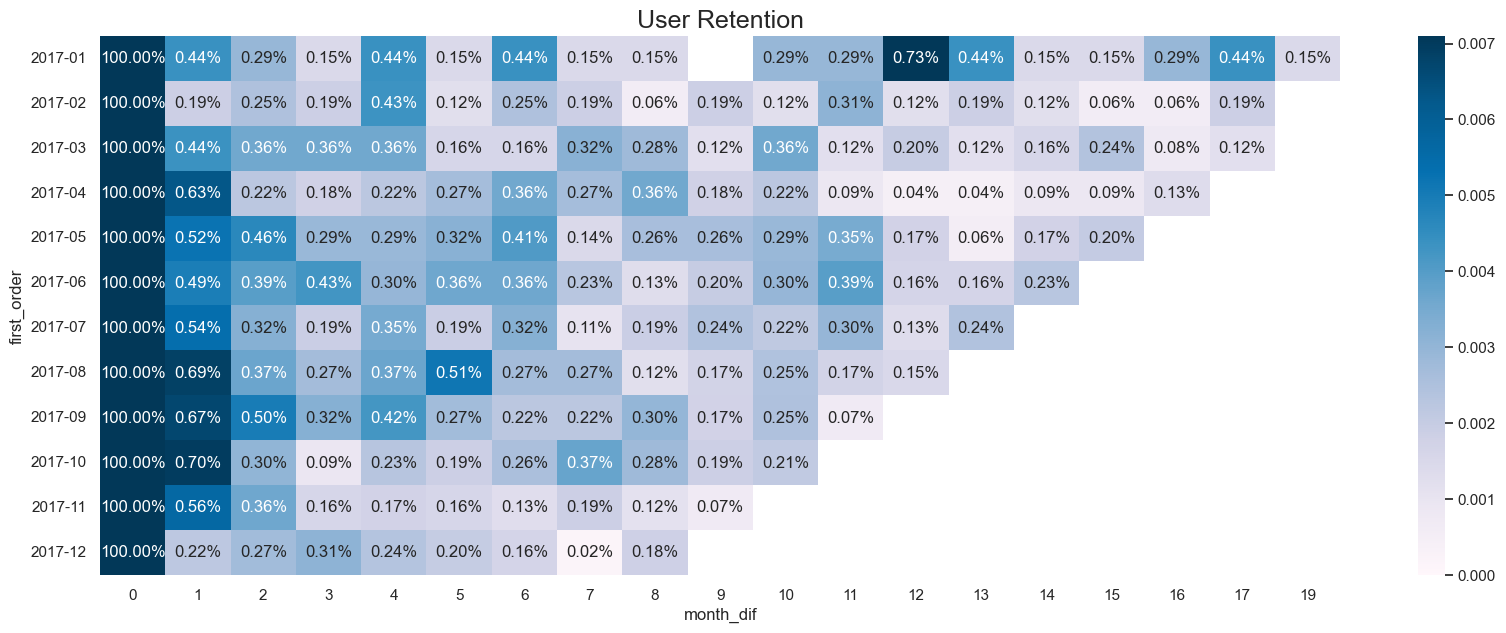

In [68]:
sns.heatmap(retention, annot = True,vmin = 0.0, vmax = 0.0071, cmap="PuBu", fmt='.2%')
plt.title('User Retention', fontsize=18)

> Из визуализации выше видно, что пользователи практически не возвращаются для совершения повторных покупок

> Нахождение когорты с самым высоким retention на третий месяц

In [69]:
retention[[3]].idxmax()

month_dif
3    2017-06
dtype: period[M]

**Ответ: *Когорта '2017-06'***

----

<h2>
    <span style="color:darkgrey">
         6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию
    </span>
</h2>

----

> Создание датафрейма `rfm_merged_df` из датафрейма совершенных покупок(согласно определению покупки из п.1) и датафрейма с товарными позициями, входящими в заказы

In [70]:
rfm_merged_df = order_df_completed_purchases.merge(items_df[['order_id', 'product_id', 'price']], on = ('order_id'))
rfm_merged_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,price
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,87285b34884572647811a353c7ac498a,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,595fac2a385ac33a80bd5114aec74eb8,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,aa4383b373c6aca5d8797843e5594415,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,d0b61bfb1de832b15ba9d266ca96e5b0,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,65266b2da20d04dbe00c5c2d3bb7859e,19.90


> Удаление лишних колонок

In [71]:
rfm_merged_df = rfm_merged_df.drop(columns=['order_status', 'order_purchase_timestamp', 'order_delivered_carrier_date',\
                           'order_delivered_customer_date', 'order_estimated_delivery_date'])
rfm_merged_df.head()

,order_id,customer_id,order_approved_at,product_id,price
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,87285b34884572647811a353c7ac498a,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-26 03:24:27,595fac2a385ac33a80bd5114aec74eb8,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:55:23,aa4383b373c6aca5d8797843e5594415,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:45:59,d0b61bfb1de832b15ba9d266ca96e5b0,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 22:20:29,65266b2da20d04dbe00c5c2d3bb7859e,19.90


> Обьединение с датафреймом с данными уникальных пользоавателей

In [72]:
rfm_merged_df = rfm_merged_df.merge(customer_df[['customer_id','customer_unique_id']], on = ('customer_id'))
rfm_merged_df.head()

,order_id,customer_id,order_approved_at,product_id,price,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,87285b34884572647811a353c7ac498a,29.99,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-26 03:24:27,595fac2a385ac33a80bd5114aec74eb8,118.70,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:55:23,aa4383b373c6aca5d8797843e5594415,159.90,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:45:59,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 22:20:29,65266b2da20d04dbe00c5c2d3bb7859e,19.90,72632f0f9dd73dfee390c9b22eb56dd6


> Удаление лишних колонок

In [73]:
rfm_merged_df = rfm_merged_df.drop(columns=['customer_id', 'product_id'])
rfm_merged_df.head()

,order_id,order_approved_at,price,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15,29.99,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 03:24:27,118.70,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:55:23,159.90,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:45:59,45.00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 22:20:29,19.90,72632f0f9dd73dfee390c9b22eb56dd6


> Так как датасет уже устарел, нет возможности при расчетах `recency` использовать текущую дату, поэтому используется последняя дата в датасете с добавлением к ней одного дня
>
> Создание переменной в которой будет хранится последняя дата плюс один день

In [74]:
today = rfm_merged_df['order_approved_at'].max() + timedelta(days=1)
today

Timestamp('2018-08-30 15:10:26')

> Имеются данные за два года, берется в расчет весь период

In [75]:
rfm_merged_df['order_approved_at'].max() - rfm_merged_df['order_approved_at'].min()

Timedelta('713 days 02:53:48')

In [76]:
period = 714

> Добавление столбца `days_since_order` с количеством дней между датой покупки и `today`

In [77]:
# Использование лямбда-функции для вычисления разницы между датой в столбце 'order_approved_at' и 'today'
rfm_merged_df['days_since_order'] = rfm_merged_df['order_approved_at'].apply(lambda x: (today - x).days)
rfm_merged_df.head()

,order_id,order_approved_at,price,customer_unique_id,days_since_order
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15,29.99,7c396fd4830fd04220f754e42b4e5bff,332
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 03:24:27,118.70,af07308b275d755c9edb36a90c618231,35
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:55:23,159.90,3a653a41f6f9fc3d2a113cf8398680e8,22
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:45:59,45.00,7c142cf63193a1473d2e66489a9ae977,284
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 22:20:29,19.90,72632f0f9dd73dfee390c9b22eb56dd6,197


> Создание датафрейма `rfm` с уникальными пользователями, количеством дней с момента последнего заказа (`recency`), общим количеством заказов за последний период (`frequency`)

In [78]:
aggr = {
    'days_since_order': lambda x: x.min(), # вычисление количества дней с момента последнего заказа (recency)
    'order_approved_at': lambda x: len([d for d in x if d >= today - timedelta(days=period)]), # вычисление числа элементов в списке за последний период (frequency);
}
rfm = rfm_merged_df.groupby('customer_unique_id').agg(aggr).reset_index()
rfm.rename(columns={'days_since_order': 'recency', 'order_approved_at': 'frequency'}, inplace=True)
rfm.head()

,customer_unique_id,recency,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1
2,0000f46a3911fa3c0805444483337064,537,1
3,0000f6ccb0745a6a4b88665a16c9f078,321,1
4,0004aac84e0df4da2b147fca70cf8255,288,1


> Добавление столбца с суммой покупок `monetary`

In [79]:
rfm['monetary'] = rfm['customer_unique_id']\
                  .apply(lambda x: rfm_merged_df[(rfm_merged_df['customer_unique_id'] == x)\
                  & (rfm_merged_df['order_approved_at'] >= today - timedelta(days=period))]['price'].sum())
rfm.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00


> Расчет квантилей для RFM параметров

In [80]:
quintiles = rfm[['recency', 'frequency', 'monetary']].quantile([.2, .4, .6, .8])
quintiles

,recency,frequency,monetary
0.2,92.0,1.0,39.9
0.4,177.0,1.0,69.9
0.6,268.0,1.0,109.9
0.8,381.8,1.0,179.9


> Т.к. при использовании квантилей параметр `frequency` имеет одно значение, имеет смысл использовать разграничение по собственным условиям.
>
> Построение гистограммы распределения значений для параметра `frequency`

<AxesSubplot:title={'center':'Распределения значений для параметра frequency'}, xlabel='frequency', ylabel='Count'>

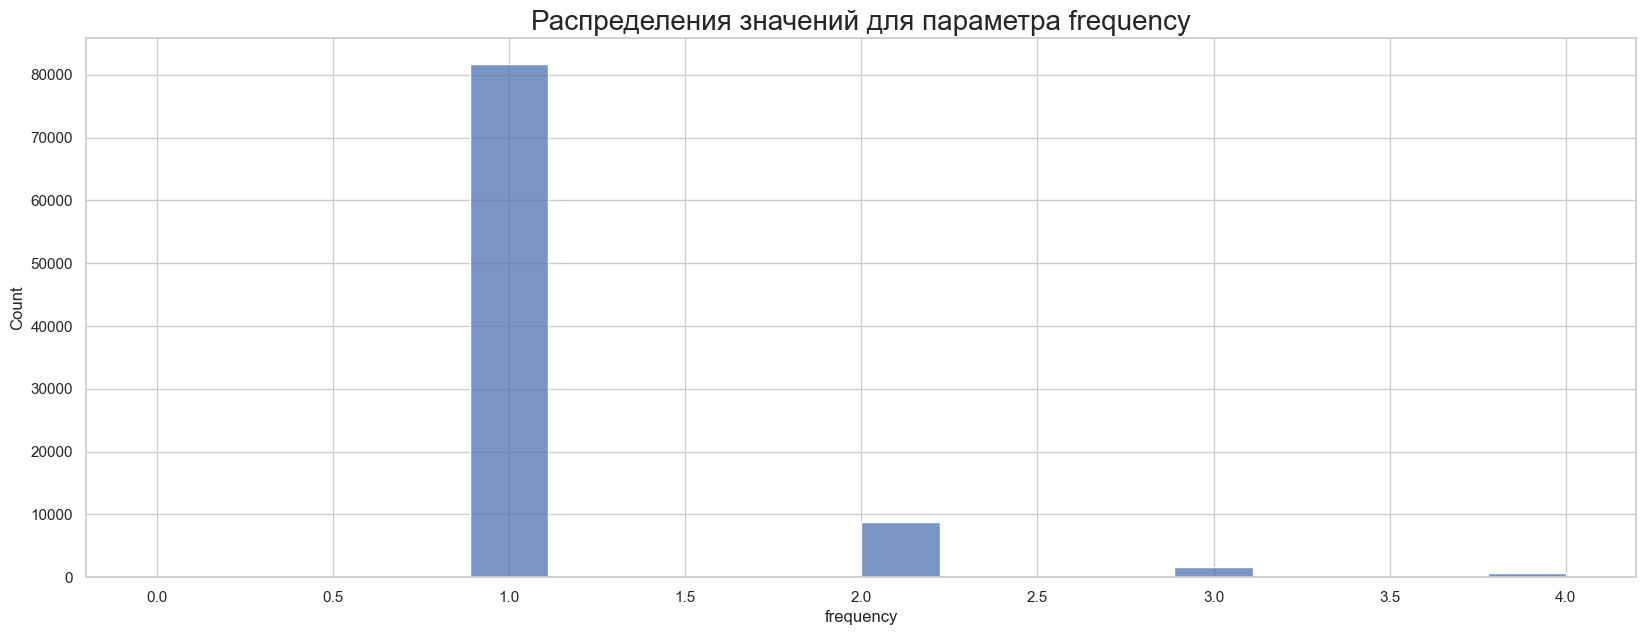

In [81]:
plt.title('Распределения значений для параметра frequency', fontsize=20)
sns.histplot(rfm[rfm['frequency'] < 5].frequency) #избавление от выбросов для получения более наглядной картины

> Исходня из данных выше категории параметра `frequency` будут иметь следующие границы:
>1. Покупатели совершившие более 5 заказов - частые покупки
>2. Покупатели совершившие от 2 до 5 заказов - редкие покупки;
>3. Покупатели совершившие только один заказ - единоразовые покупки;

In [82]:
def f_score(x):
    if x == 1:
        return 3
    elif (x >= 2) and (x <= 5):
        return 2
    else:
        return 1

rfm['f'] = rfm['frequency'].apply(f_score)
rfm.head()

,customer_unique_id,recency,frequency,monetary,f
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,3
2,0000f46a3911fa3c0805444483337064,537,1,69.00,3
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,3
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,3


> Построение гистограммы распределения значений для параметра `recency`

<AxesSubplot:title={'center':'Распределения значений для параметра recency'}, xlabel='recency', ylabel='Count'>

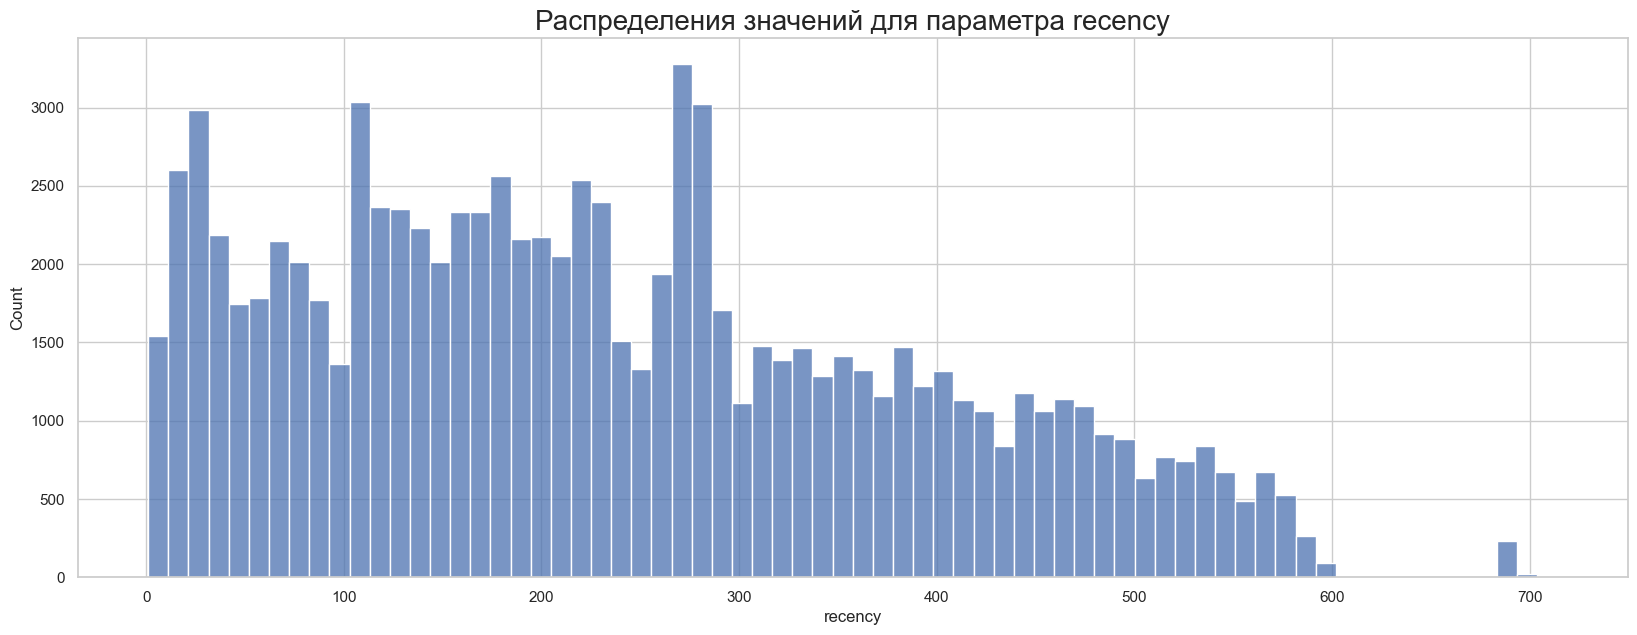

In [83]:
plt.title('Распределения значений для параметра recency', fontsize=20)
sns.histplot(rfm.recency)

> Исходня из данных выше категории параметра `recency` будут иметь следующие границы:
>1. Покупатели совершившие заказ до 100 дней назад - делали заказ недавно;
>2. Покупатели совершившие заказ от 100 до 300 дней назад - делали заказ относительно недавно;
>3. Покупатели совершившие заказ более 300 дней назад - делали заказ давно

In [84]:
def r_score(x):
    if x < 100:
        return 1
    elif (x >= 100) and (x <= 300):
        return 2
    else:
        return 3

rfm['r'] = rfm['recency'].apply(r_score)
rfm.head()

,customer_unique_id,recency,frequency,monetary,f,r
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,3,2
2,0000f46a3911fa3c0805444483337064,537,1,69.00,3,3
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,3,3
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,3,2


> Построение гистограммы распределения значений для параметра `monetary`

<AxesSubplot:title={'center':'Распределения значений для параметра monetary'}, xlabel='monetary', ylabel='Count'>

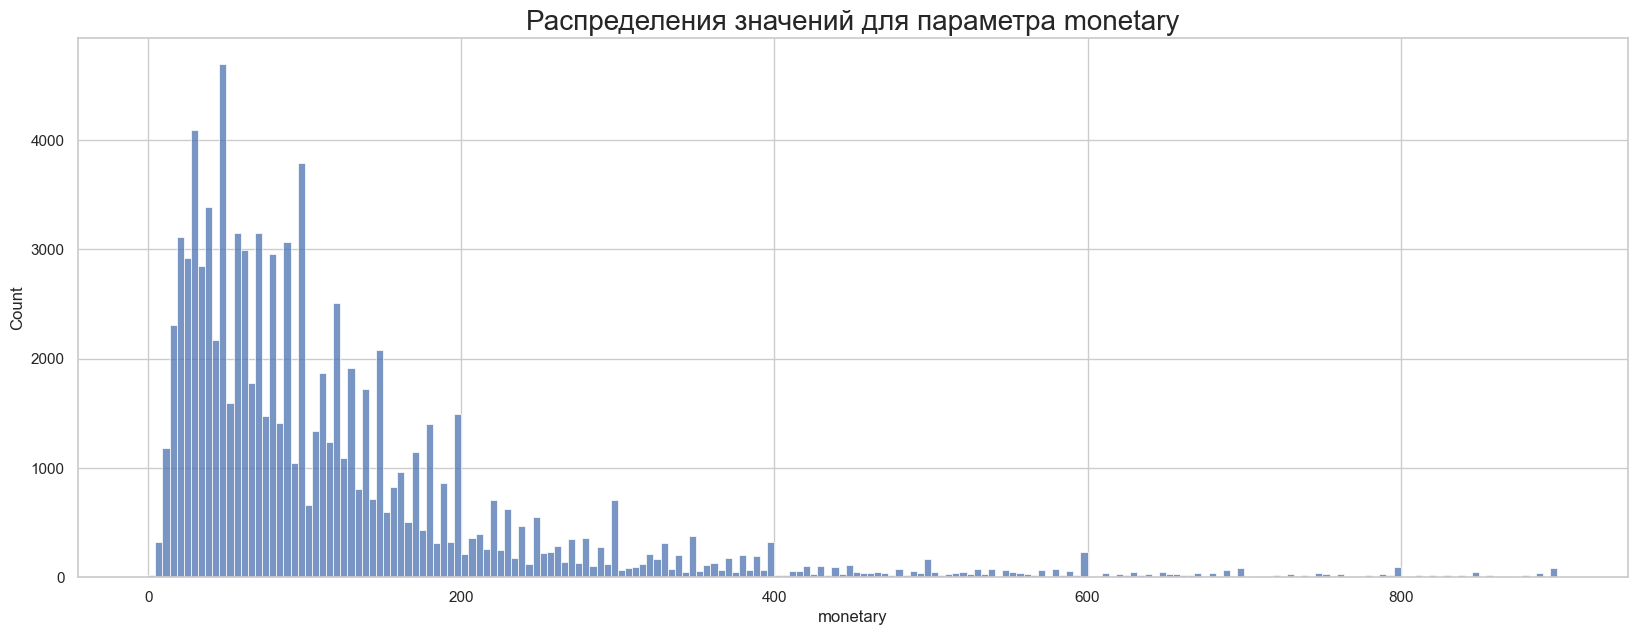

In [85]:
plt.title('Распределения значений для параметра monetary', fontsize=20)
sns.histplot(rfm[rfm['monetary'] < 900].monetary) #избавление от выбросов для получения более наглядной картины

> Исходня из данных выше категории параметра `monetary` будут иметь следующие границы:
>1. Покупатели потратившие более 600 - потратили много;
>2. Покупатели потратившие от 200 до 600 - умеренные траты;
>3. Покупатели потратившие до 200 - потратили мало;

In [86]:
def m_score(x):
    if x < 200:
        return 3
    elif (x >= 200) and (x <= 600):
        return 2
    else:
        return 1

rfm['m'] = rfm['monetary'].apply(m_score)
rfm.head()

,customer_unique_id,recency,frequency,monetary,f,r,m
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,2,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,3,2,3
2,0000f46a3911fa3c0805444483337064,537,1,69.00,3,3,3
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,3,3,3
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,3,2,3


> Добавление новой колонки `rfm_score` содержащей результирующую сигментацию:

In [87]:
rfm['rfm_score'] = rfm['r'].map(str) + rfm['f'].map(str) + rfm['m'].map(str)
rfm.head()

,customer_unique_id,recency,frequency,monetary,f,r,m,rfm_score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,2,3,233
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,3,2,3,233
2,0000f46a3911fa3c0805444483337064,537,1,69.00,3,3,3,333
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,3,3,3,333
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,3,2,3,233


<AxesSubplot:title={'center':'Распределение пользователей по сегментам'}, xlabel='rfm_score', ylabel='count'>

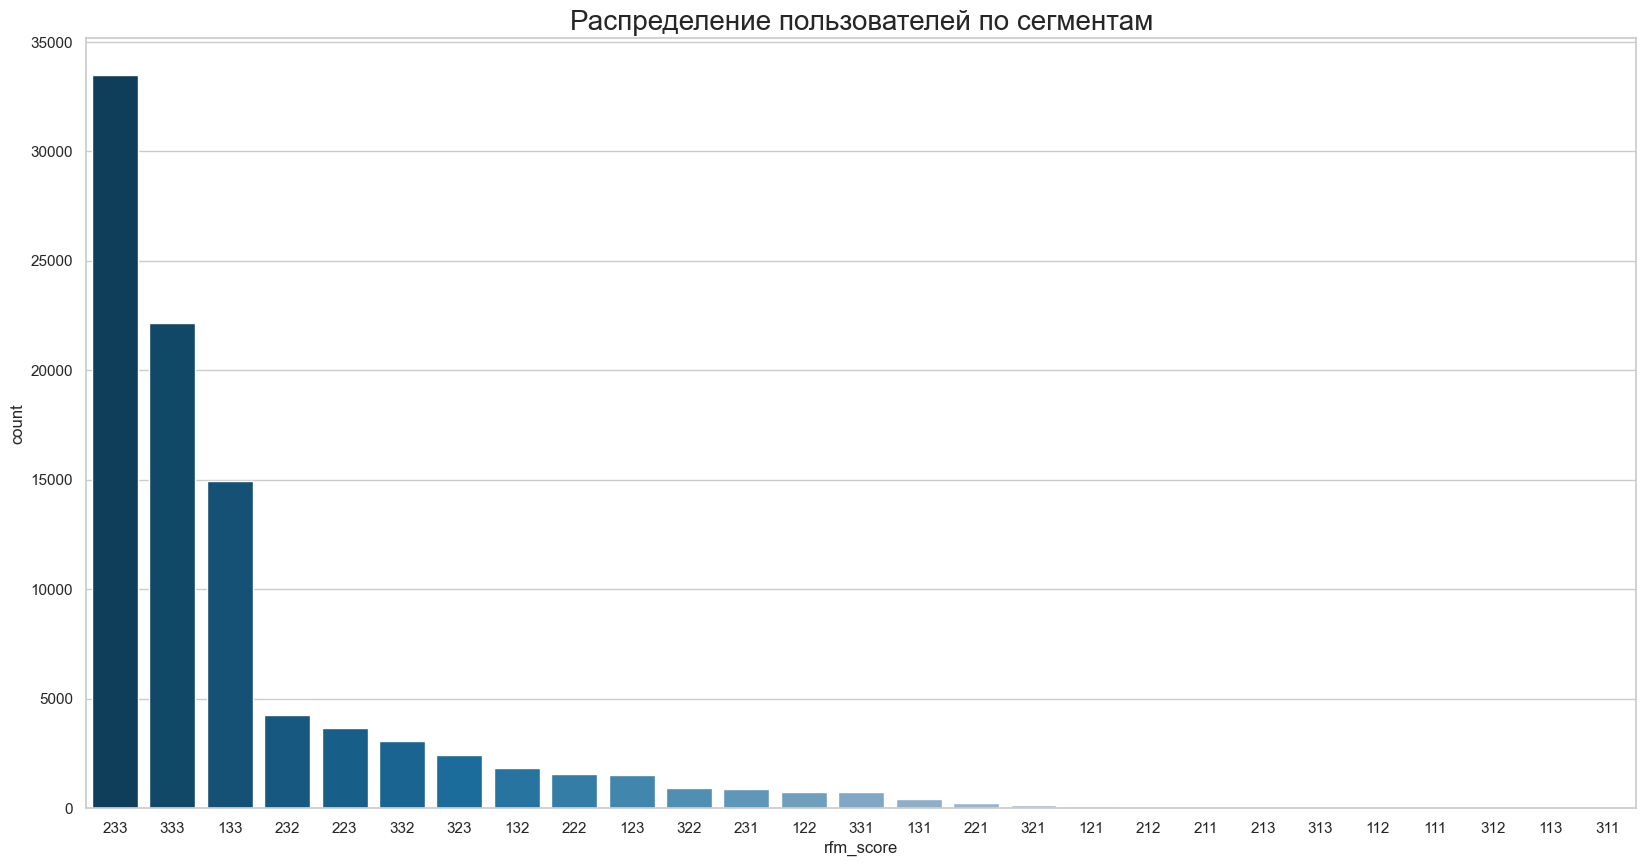

In [88]:
plt.figure(figsize=(20, 10))
plt.title('Распределение пользователей по сегментам', fontsize=20)
sns.countplot(data=rfm, x='rfm_score', palette='PuBu_r', order = rfm['rfm_score'].value_counts().index)

### Группировка сегментов и подробное описание:

1. **Finish him!** - не перспективные сегменты. Покупатели, которые сделали до 5 заказов, траты маленькие или умеренные, заказ был сделан относительно недавно или давно.

    - 223 - делали заказ относительно недавно; редкие покупки; потратили мало;
    - 233 - делали заказ относительно недавно; единоразовые покупки; потратили мало;
    - 333 - делали заказ давно; единоразовые покупки; потратили мало;
    - 332 - делали заказ давно; единоразовые покупки; умеренные траты;
    - 323 - делали заказ давно; редкие покупки; потратили мало;


2. **Try to come back** - покупатели, которые давно и относительно недавно совершали большие и умеренные траты или совершали частые покупки на не большие суммы.

    - 232 - делали заказ относительно недавно; единоразовые покупки; умеренные траты
    - 222 - делали заказ относительно недавно; редкие покупки; умеренные траты;
    - 331 - делали заказ давно; единоразовые покупки; потратили много;
    - 321 - делали заказ давно; редкие покупки; потратили много;
    - 322 - делали заказ давно; редкие покупки; умеренные траты;
    - 313 - делали заказ давно; частые покупки; потратили мало;
    - 312 - делали заказ давно; частые покупки; умеренные траты;
    - 311 - делали заказ давно; частые покупки; потратили много;


3. **Fresh blood** - новые покупатели, которые недавно и относительно недавно совершали мало покупок на не большие суммы или частые покупки тоже на малые суммы. 
    - 133 - делали заказ недавно; единоразовые покупки; потратили мало;
    - 132 - делали заказ недавно; единоразовые покупки; умеренные траты;
    - 123 - делали заказ недавно; редкие покупки; потратили мало;
    - 213 - делали заказ относительно недавно; частые покупки; потратили мало;
    - 113 - делали заказ недавно; частые покупки; потратили мало;


4. **Gold baby** - перспективные покупатели, которые недавно и относительно недавно совершали не много покупок, но на большие суммы или частые покупки на не большие суммы.
    - 231 - делали заказ относительно недавно; единоразовые покупки; потратили много;
    - 122 - делали заказ недавно; редкие покупки; умеренные траты;
    - 131 - делали заказ недавно; единоразовые покупки; потратили много;
    - 221 - делали заказ относительно недавно; редкие покупки; потратили много;
    - 212 - делали заказ относительно недавно;частые покупки; умеренные траты;
    - 211 - делали заказ относительно недавно;частые покупки; потратили много;
    

5. **Super hero** - лояльные покупатели, которые совершают довольно частые покупки на большие суммы и заказывали не так давно. 
    - 121 - делали заказ недавно; редкие покупки; потратили много;
    - 111 - делали заказ недавно; частые покупки; потратили много;
    - 112 - делали заказ недавно; частые покупки; умеренные траты;

> Создание словаря с распределением сигментов на группы

In [89]:
segt_map = {
    r'223': 'Finish him!',
    r'233': 'Finish him!',
    r'333': 'Finish him!',
    r'332': 'Finish him!',
    r'323': 'Finish him!',
    r'232': 'Try to come back',
    r'222': 'Try to come back',
    r'331': 'Try to come back',
    r'321': 'Try to come back',
    r'322': 'Try to come back',
    r'313': 'Try to come back',
    r'312': 'Try to come back',
    r'311': 'Try to come back',
    r'133': 'Fresh blood',
    r'132': 'Fresh blood',
    r'123': 'Fresh blood',
    r'213': 'Fresh blood',
    r'113': 'Fresh blood',
    r'231': 'Gold baby',
    r'122': 'Gold baby',
    r'131': 'Gold baby',
    r'221': 'Gold baby',
    r'212': 'Gold baby',
    r'211': 'Gold baby',
    r'121': 'Super hero',
    r'111': 'Super hero',
    r'112': 'Super hero',
}

> Добавление колонки `segment` в которой присваевается группа каждому покупателю

In [90]:
rfm['segment'] = rfm['r'].map(str) + rfm['f'].map(str) + rfm['m'].map(str)
rfm['segment'] = rfm['segment'].replace(segt_map, regex=True)
rfm.head()

,customer_unique_id,recency,frequency,monetary,f,r,m,rfm_score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,2,3,233,Finish him!
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,3,2,3,233,Finish him!
2,0000f46a3911fa3c0805444483337064,537,1,69.00,3,3,3,333,Finish him!
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,3,3,3,333,Finish him!
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,3,2,3,233,Finish him!


> Вывод количества пользователей для каждой из групп и постороение гистограммы

In [91]:
rfm['segment'].value_counts()

Finish him!         64739
Fresh blood         18373
Try to come back     7705
Gold baby            2371
Super hero            149
Name: segment, dtype: int64

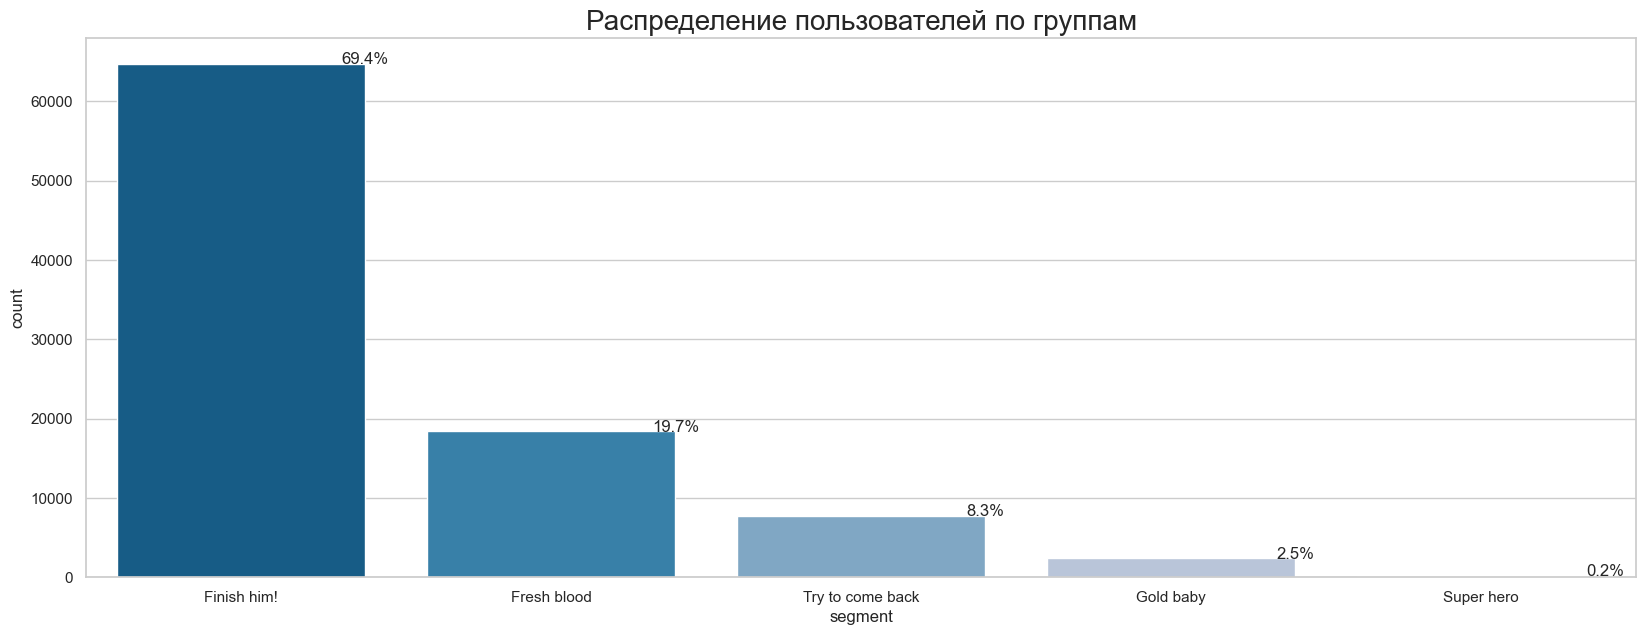

In [92]:
total = float(len(rfm))
ax = sns.countplot(data=rfm, x="segment", palette='PuBu_r', order = rfm['segment'].value_counts().index)
plt.title('Распределение пользователей по группам', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

### Заключение по RFM-сегментации:

- Самая крупная группа это **Finish him!**, т.е. большинство покупателей не становятся постоянными и не возвращаются после покупки;

- **Try to come back** - довольно крупная группа пользователей, которых необходимо повторно заинтересовать;

- Особое внимание следует уделить группам **Fresh blood** и **Gold baby**, т.к. являются потенциально лояльными клиентами и могут увеличить их процент, что в свою очередь, увеличит стабильную прибыль, которую компания получает от лояльных клиентов;

- Самая лояльныая, и в тоже время, самая малочисленная группа - **Super Hero**. Необходимо всячески удерживать эту группу.

Необходимо разобраться в причинах настолько большого оттока покупателей и чрезвычайно малого количества лояльных покупателей.